# Принятие решений в бизнесе на основе анализа A/B-теста

**Заказчик исследования:** отдел маркетинга крупного интернет-магазина.

**Цель исследования:** приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты, которые будут способствовать увеличению выручки интернет-магазина.

Исследование базируется на данных крупного интернет-магазина.


## Описание данных

**Описание полей в датасетах**

Гипотезы - `/datasets/hypothesis.csv`

- `Hypothesis` — краткое описание гипотезы,
- `Reach` — охват пользователей по 10-балльной шкале,
- `Impact` — влияние на пользователей по 10-балльной шкале,
- `Confidence` — уверенность в гипотезе по 10-балльной шкале,
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Заказы - `/datasets/orders.csv`

- `transactionId` — идентификатор заказа,
- `visitorId` — идентификатор пользователя, совершившего заказ,
- `date` — дата, когда был совершён заказ,
- `revenue` — выручка заказа,
- `group` — группа A/B-теста, в которую попал заказ.

Посетители - `/datasets/visitors.csv` 
- `date` — дата,
- `group` — группа A/B-теста,
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

## Загрузка данных

In [1]:
# Импортируем нужные библиотеки
from scipy import stats
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
# Загрузим необходимые для анализа датасеты 
data_hypothesis = pd.read_csv('/datasets/hypothesis.csv')
data_orders = pd.read_csv('/datasets/orders.csv')
data_visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
# Выведем первые строки каждого набора данных. Изучим общую информацию о каждом датафрейме.
# получение первых cтрок таблицы data_users
pd.options.display.max_colwidth = 130
display(data_hypothesis.head())

# получение первых cтрок таблицы data_rides
display(data_orders.head())

# получение первых cтрок таблицы data_subs
display(data_visitors.head())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [4]:
# Общая информация о гипотезах
data_hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
# Общая информация о заказах
data_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [6]:
# Общая информация о посетителях
data_visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Из общей информации, выведенной методом info(), можно сделать следующие выводы:
- Имеются три таблицы - с данными о гипотезах, заказах и посетителях. 
- В данных всех таблиц отсутствуют пропуски.
- Необходимо поменять тип данных столбца `date` в таблицах с заказами и посетителями.
- Имена столбцов в датасете `data_hypothesis` необходимо привести к нижнему регистру

## Предобработка данных

In [7]:
# Поменяем тип столбца date на datetime
data_orders['date'] = pd.to_datetime(data_orders['date'])
data_visitors['date'] = pd.to_datetime(data_visitors['date'])
data_orders.info()
data_visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [8]:
# Имена столбцов в датасете `data_hypothesis` приведем к нижнему регистру
data_hypothesis.columns = data_hypothesis.columns.str.lower()
display(data_hypothesis.head())

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [9]:
# Проверим данные по заказам на дубликаты
data_orders.duplicated().sum()

0

In [10]:
# Проверим данные по посетителям на дубликаты
data_visitors.duplicated().sum()

0

In [11]:
# Имена столбцов в датасете `data_orders` приведем к нижнему регистру через `_`
data_orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']
data_orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


### Выводы

На этапе предобоаботки данных была проделана следующая работа:

- привели столбец date к типу datetime
- привели имена столбцов в датасете `data_hypothesis` к нижнему регистру
- проверили на наличие дубликатов


## Приоритизация гипотез

В файле `/datasets/hypothesis.csv` даны 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами `Reach`, `Impact`, `Confidence`, `Effort`. Приоритизируем их при помощи фреймворков `ICE` и `RICE`.

### Применим фреймворк `ICE` для приоритизации гипотез

In [12]:
# Применим фреймворк ICE для приоритизации гипотез и отсортируем их по убыванию приоритета
data_hypothesis['ICE'] = round(data_hypothesis['impact'] * data_hypothesis['confidence'] / data_hypothesis['efforts'], 2)
data_hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending= False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


По фреймворку `ICE` наиболее приоритетными оказались следующие гипотезы:
- "Запустить акцию, дающую скидку на товар в день рождения"
- "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"
- "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"

### Применим фреймворк `RICE` для приоритизации гипотез

In [13]:
# Применим фреймворк `RICE` для приоритизации гипотез и отсортируем их по убыванию приоритета.
data_hypothesis['RICE'] = round(
    data_hypothesis['reach'] * 
    data_hypothesis['impact'] * 
    data_hypothesis['confidence'] / 
    data_hypothesis['efforts'], 2)
data_hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending= False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


По фреймворку `RICE` наиболее приоритетными оказались следующие гипотезы:
- "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"
- "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"
- "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"

### Выводы

Как видим, приоритизация гипотез при применении RICE вместо ICE изменилась. 
- При применении фреймворка `ICE` наиболее приоритетными оказались гипотезы с индексами 8, 0 и 7. А при применении `RICE` наиболее приоритетными оказались гипотезы с индексами 7, 2 и 0.
- Приоритизация изменилась, так как параметр `Reach`, отвечающий за охват аудитории, оказался выше у лидирующих гипотез по фреймворку `RICE`.

## Анализ A/B-теста

В файлах `/datasets/orders.csv` и `/datasets/visitors.csv` даны результаты проведенного A/B-теста. 
Проанализируем данный А/В тест.

In [14]:
# Подготовим группы теста
groups = data_orders[['date','group']].drop_duplicates()
groups.head()

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


In [15]:
# Агрегируем данные о заказах 
orders_agg = groups.apply(
    lambda x: data_orders[np.logical_and(data_orders['date'] <= x['date'], data_orders['group'] == x['group'])]\
        .agg({
            'date': 'max', 
            'group': 'max', 
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum'
        }), axis=1).sort_values(by=['date','group'])
orders_agg.head()

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


In [16]:
# Агрегируем данные о посетителях
visitors_agg = groups.apply(
    lambda x: data_visitors[np.logical_and(data_visitors['date'] <= x['date'], data_visitors['group'] == x['group'])]\
        .agg({
            'date': 'max',
            'group': 'max',
            'visitors': 'sum'
        }), axis=1).sort_values(by=['date','group'])
visitors_agg.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [17]:
# Объединим агрегированные данные в одной таблице и переименуем столбцы
cumulative_data = orders_agg.merge(visitors_agg, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


### Кумулятивная выручка по группам

Построим график кумулятивной выручки по группам, сделаем выводы и предположения.

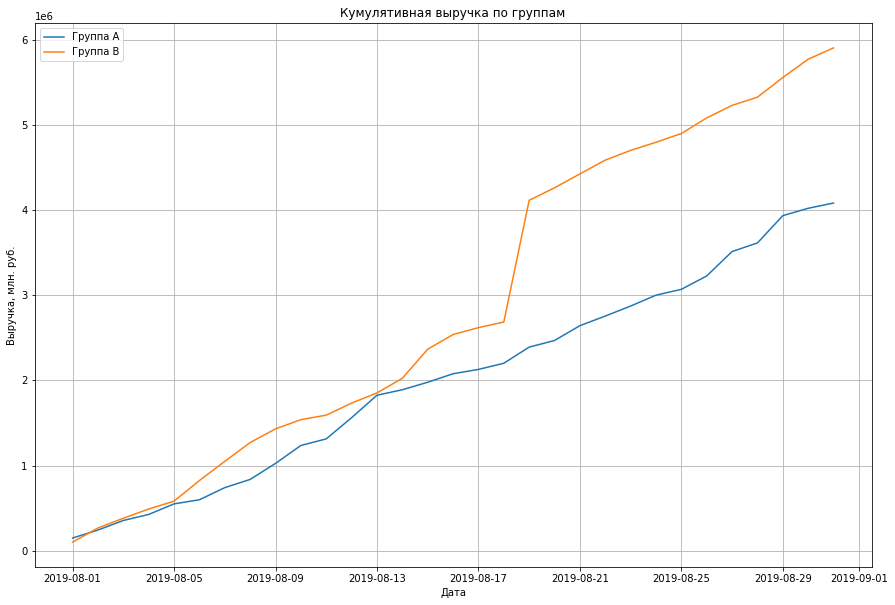

In [18]:
# Количество заказов и выручка по дням в группе А
cumulative_revenue_A = cumulative_data[cumulative_data['group'] == 'A'][['date', 'revenue', 'orders']]

# Количество заказов и выручка по дням в группе В
cumulative_revenue_B = cumulative_data[cumulative_data['group'] == 'B'][['date', 'revenue', 'orders']]

# Строим график
plt.figure(figsize=(15, 10))
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label='Группа A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label='Группа B')
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка, млн. руб.')
plt.grid()
plt.legend()
plt.show()

По графику мы видим, что до середины теста выручка распределялась равномерно между двумя группами. Затем выручка группы B резко увеличилась. Это может говорить или о всплесках числа заказов, или о появлении очень дорогих заказов.

### Кумулятивный средний чек по группам

Построим график кумулятивного среднего чека по группам, сделаем выводы и предположения.

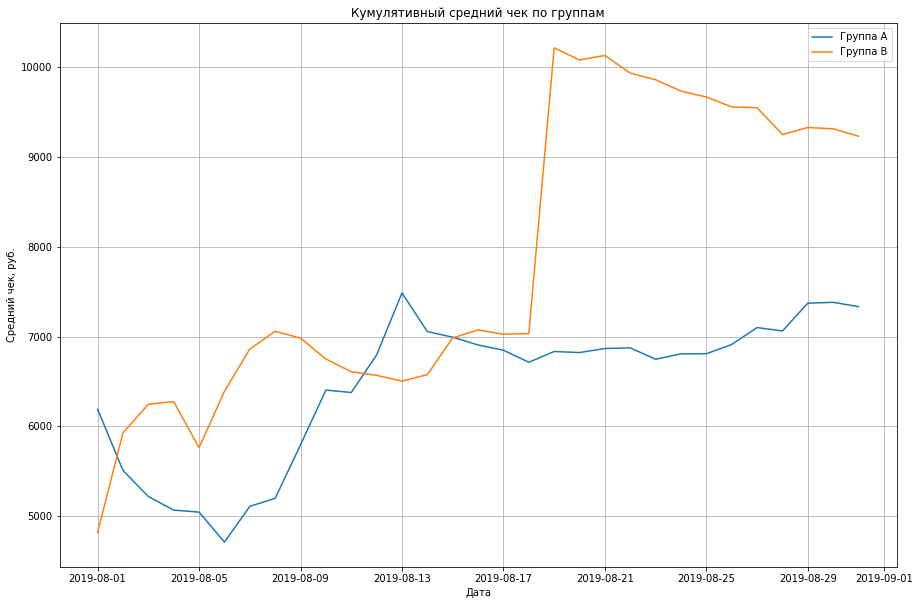

In [19]:
plt.figure(figsize=(15, 10))
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'] / cumulative_revenue_A['orders'], label='Группа A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'] / cumulative_revenue_B['orders'], label='Группа B')
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('Cредний чек, руб.')
plt.grid()
plt.legend()
plt.show()

- Примерно на середине теста мы видим резкий рост среднего чека группы В, а у группы А средний чек немного идет на временный спад. Затем у группы В начинается спад после скачка, а у группы А начинается подъем.
- В целом кумулятивный средний чек группы А имеет более плавный график, в отличии от группы B.
- Кумулятивное значение среднего чека обеих групп стабилизируется к концу теста.

### Относительное изменение кумулятивного среднего чека

Построим график относительного изменения кумулятивного среднего чека группы B к группе A, сделаем выводы и предположения.

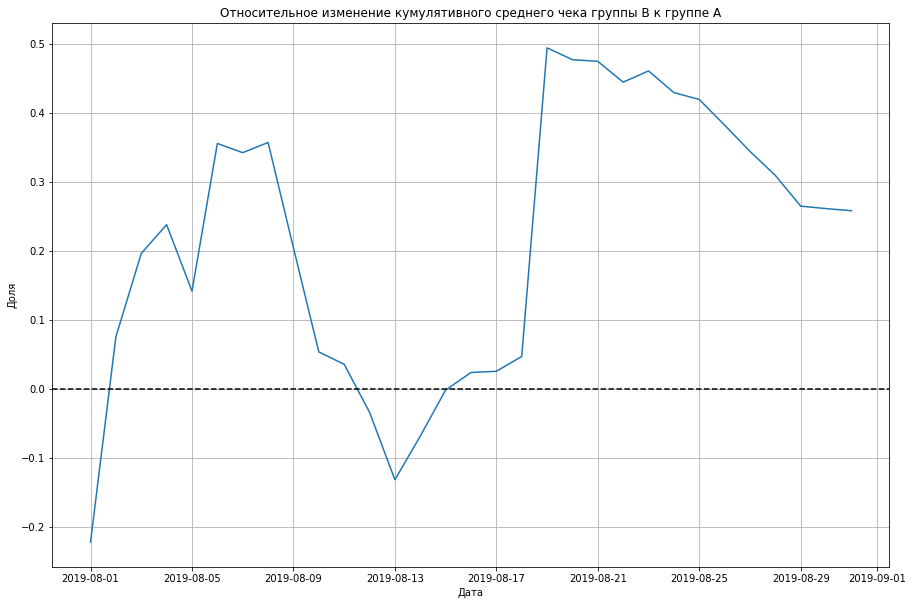

In [20]:
# Объединим данные по группам
cumulative_revenue = cumulative_revenue_A.merge(
    cumulative_revenue_B, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['_A', '_B']
)

# Построим график
plt.figure(figsize=(15, 10))
plt.plot(
    cumulative_revenue['date'], 
    (
        cumulative_revenue['revenue_B'] / cumulative_revenue['orders_B']) / (
            cumulative_revenue['revenue_A'] / cumulative_revenue['orders_A']
        ) - 1
    )
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Доля')
plt.grid()
plt.show()

По графику видны резкие изменения среднего чека. Скорее всего, в эти даты были совершены аномальные заказы.

### Кумулятивное среднее количество заказов на посетителя

Построим график кумулятивного среднего количества заказов на посетителя по группам, сделаем выводы и предположения.

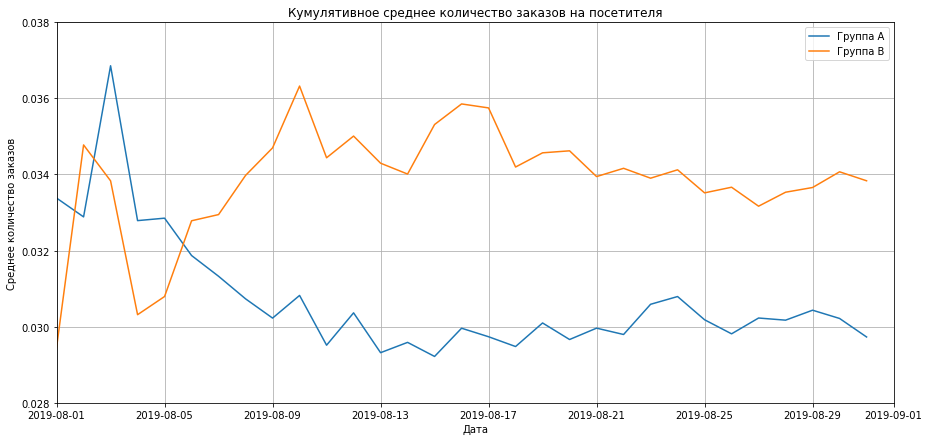

In [21]:
# Посчитаем среднее количество заказов на посетителя по группам
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']

# Отделим данные по группе A
cumulative_data_A = cumulative_data[cumulative_data['group']=='A']

# Отделим данные по группе B
cumulative_data_B = cumulative_data[cumulative_data['group']=='B']

# Построим график
plt.figure(figsize=(15, 7))
plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], label='Группа A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], label='Группа B')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0.028, 0.038])
plt.title('Кумулятивное среднее количество заказов на посетителя')
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов')
plt.legend()
plt.grid()
plt.show()

По графику видим: 
- в начале теста конверсия группы А была выше, чем у группы В
- в начале августа конверсия группы B начала расти
- затем конверсия группы В зафиксировались в положении выше А

### Относительное изменение кумулятивного среднего количества заказов

Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A, сделаем выводы и предположения.

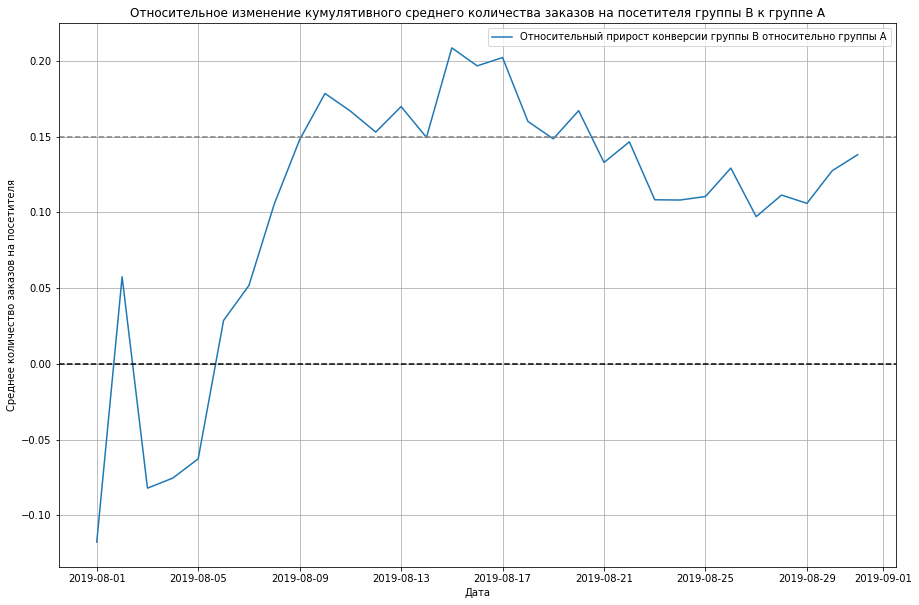

In [22]:
# Объединим данные по конверсии
cumulative_data_AB = cumulative_data_A[['date','conversion']].merge(
    cumulative_data_B[['date','conversion']], 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['_A', '_B']
)

# Построим график
plt.figure(figsize=(15, 10))
plt.plot(
    cumulative_data_AB['date'], 
    cumulative_data_AB['conversion_B'] / cumulative_data_AB['conversion_A'] - 1, 
    label="Относительный прирост конверсии группы B относительно группы A"
)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов на посетителя')
plt.legend()
plt.grid()
plt.show()

По графику видно, что относительное изменение кумулятивного среднего количества заказов на посетителя группы B выходит вперед после 5-го дня теста и лидирует с преимуществом примерно 15% до конца теста.

### Количество заказов по пользователям

Построим точечный график количества заказов по пользователям, сделаем выводы и предположения.

In [23]:
# Посчитаем количество заказов по пользователям 
orders_by_users = (
    data_orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users.columns = ['visitor_id', 'transaction_id']
orders_by_users.sort_values(by='transaction_id', ascending=False).head()

,visitor_id,transaction_id
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


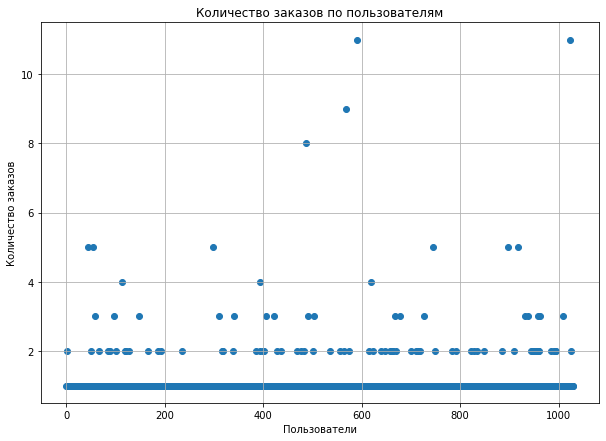

In [24]:
# Построим график
x_values = pd.Series(range(0, len(orders_by_users)))
plt.figure(figsize=(10, 7))
plt.scatter(x_values, orders_by_users['transaction_id'])
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')
plt.title("Количество заказов по пользователям")
plt.grid()
plt.show()

Как видим, небольшое количество пользователей сделали заказ более двух раз. Значит, что они могут быть аномальными.

### Аномальные пользователи

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя и выберим границу для определения аномальных пользователей.

In [25]:
# Посчитаем 95-й и 99-й перцентили количества заказов на пользователя
percentiles = np.percentile(orders_by_users['transaction_id'], [95, 99])
print(f"95-й перцентиль: {percentiles[0]}, 99-й перцентиль: {percentiles[1]}")

min_normal_orders_count = percentiles[1]
print(f"Минимальное количество заказов для \"номальных\" пользователей: {min_normal_orders_count}")

95-й перцентиль: 2.0, 99-й перцентиль: 4.0
Минимальное количество заказов для "номальных" пользователей: 4.0


- Не более 5% пользователей оформляли больше 2х заказов
- 1% пользователей заказывали больше 4х раз
- Тех пользователей, которые совершили более 4 заказов, примем за аномальных.

### Стоимости заказов

Построим точечный график стоимостей заказов, сделаем выводы и предположения.

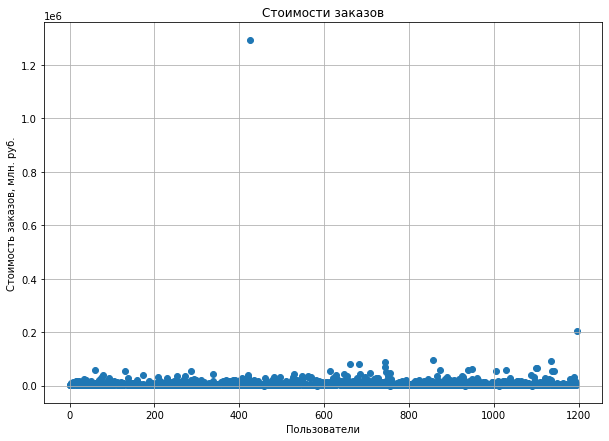

In [26]:
# Построим график
x_values = pd.Series(range(0, len(data_orders['revenue'])))
plt.figure(figsize=(10, 7))
plt.scatter(x_values, data_orders['revenue']) 
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказов, млн. руб.')
plt.title('Стоимости заказов')
plt.grid()
plt.show()

В среднем стоимость заказов не превышает 200 000р, есть пару выбросов ( около 200 тыс. и 1,3 млн.). Посчитаем выборочные процентили.

### Аномальные заказы

Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберим границу для определения аномальных заказов.

In [27]:
percentiles = np.percentile(data_orders['revenue'] , [95, 99])
print(f"95-й перцентиль: {round(percentiles[0], 3)}, 99-й перцентиль: {round(percentiles[1], 3)}")

min_normal_order_sum = round(percentiles[0])
print(f"Минимальная сумма заказа для \"номальных\" пользователей: {min_normal_order_sum}")

95-й перцентиль: 28000.0, 99-й перцентиль: 58233.2
Минимальная сумма заказа для "номальных" пользователей: 28000


- Не более 5% пользователей потратили более 28 тысяч рублей
- 1% пользователей потратили более 58,2 тысяч рублей
- Примем за аномальных заказы те, которые превышают 28 тысяч рублей

### Расчет статистической значимости по «сырым» данным

#### Различия в среднем количестве заказов на посетителя

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделаем выводы и предположения.

1) Создадим переменные `orders_by_users_A` и `orders_by_users_B` со столбцами `user_id` и `orders`, где для пользователей, совершивших хотя бы 1 заказ, будет указано число заказов. 

2) Объявим переменные sample_A и sample_B, в которых пользователям с заказами будет соответствовать число заказов пользователя. А пользователям без заказов — нули. 

Эти действия нужны, чтобы подготовить выборки к проверке критерием Манна-Уитни:
- H0: Среднее количество заказов на посетителя групп A и B равны, статистически значимых отличий нет;
- H1: Среднем количество заказов на посетителя групп A и B различны, статистически значимые отличия есть.

In [28]:
# Посчитаем количество пользователей группы А на каждую дату
visitors_daily_A = data_visitors[data_visitors['group'] == 'A'][['date', 'visitors']]
visitors_daily_A.columns = ['date', 'visitors_A']
visitors_daily_A.head()

,date,visitors_A
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756


In [29]:
# Посчитаем количество пользователей группы А на каждую дату с накоплением
visitors_A = visitors_daily_A.apply(
    lambda x: visitors_daily_A[visitors_daily_A['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_A': 'sum'}
    ),
    axis=1,
)
visitors_A.columns = ['date', 'visitors_A_sum' ]
visitors_A.head()

,date,visitors_A_sum
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


In [30]:
# Посчитаем количество пользователей группы В на каждую дату
visitors_daily_B = data_visitors[data_visitors['group'] == 'B'][['date', 'visitors']]
visitors_daily_B.columns = ['date', 'visitors_B']
visitors_daily_B.head()

,date,visitors_B
31,2019-08-01,713
32,2019-08-02,581
33,2019-08-03,509
34,2019-08-04,770
35,2019-08-05,707


In [31]:
# Посчитаем количество пользователей группы В на каждую дату с накоплением
visitors_B = visitors_daily_B.apply(
    lambda x: visitors_daily_B[visitors_daily_B['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_B': 'sum'}
    ),
    axis=1,
)
visitors_B.columns = ['date', 'visitors_B_sum' ]
visitors_B.head()

,date,visitors_B_sum
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


In [32]:
# Посчитаем количество заказов и их сумму в группе A на каждую дату
orders_daily_A = (
    data_orders[data_orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
        .groupby('date', as_index=False)
        .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_A.columns = ['date', 'orders_A', 'revenue_A']
orders_daily_A.head()

,date,orders_A,revenue_A
0,2019-08-01,24,148579
1,2019-08-02,20,93822
2,2019-08-03,24,112473
3,2019-08-04,16,70825
4,2019-08-05,25,124218


In [33]:
# Посчитаем количество заказов и их сумму в группе A на каждую дату с накоплением
orders_A = orders_daily_A.apply(
    lambda x: orders_daily_A[orders_daily_A['date'] <= x['date']].agg(
        {'date': 'max', 'orders_A': 'sum', 'revenue_A': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_A.columns = ['date', 'orders_A_sum', 'revenue_A_sum']
orders_A.head()

,date,orders_A_sum,revenue_A_sum
0,2019-08-01,24,148579
1,2019-08-02,44,242401
2,2019-08-03,68,354874
3,2019-08-04,84,425699
4,2019-08-05,109,549917


In [34]:
# Посчитаем количество заказов и их сумму в группе B на каждую дату
orders_daily_B = (
    data_orders[data_orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
        .groupby('date', as_index=False)
        .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_B.columns = ['date', 'orders_B', 'revenue_B']
orders_daily_B.head()

,date,orders_B,revenue_B
0,2019-08-01,21,101217
1,2019-08-02,24,165531
2,2019-08-03,16,114248
3,2019-08-04,17,108571
4,2019-08-05,23,92428


In [35]:
# Посчитаем количество заказов и их сумму в группе B на каждую дату с накоплением
orders_B = orders_daily_B.apply(
    lambda x: orders_daily_B[orders_daily_B['date'] <= x['date']].agg(
        {'date': 'max', 'orders_B': 'sum', 'revenue_B': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_B.columns = ['date', 'orders_B_sum', 'revenue_B_sum']
orders_B.head()

,date,orders_B_sum,revenue_B_sum
0,2019-08-01,21,101217
1,2019-08-02,45,266748
2,2019-08-03,61,380996
3,2019-08-04,78,489567
4,2019-08-05,101,581995


In [36]:
# Объединим полученные выше данные
all_data = (orders_daily_A
    .merge(orders_daily_B, left_on='date', right_on='date', how='left')
    .merge(orders_A, left_on='date', right_on='date', how='left')
    .merge(orders_B, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_A, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_B, left_on='date', right_on='date', how='left')
    .merge(visitors_A, left_on='date', right_on='date', how='left')
    .merge(visitors_B, left_on='date', right_on='date', how='left')
)
all_data.head()

,date,orders_A,revenue_A,orders_B,revenue_B,orders_A_sum,revenue_A_sum,orders_B_sum,revenue_B_sum,visitors_A,visitors_B,visitors_A_sum,visitors_B_sum
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [37]:
# Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой.

orders_by_users_A = (
    data_orders[data_orders['group'] == 'A']
        .groupby('visitor_id', as_index=False)
        .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_A.columns = ['visitor_id', 'transaction_id']

orders_by_users_B = (
    data_orders[data_orders['group'] == 'B']
        .groupby('visitor_id', as_index=False)
        .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_B.columns = ['visitor_id', 'transaction_id']

sample_A = pd.concat([
    orders_by_users_A['transaction_id'], 
    pd.Series(0, index=np.arange(all_data['visitors_A'].sum() - len(orders_by_users_A['transaction_id'])), name='orders')
],axis=0)

sample_B = pd.concat([
    orders_by_users_B['transaction_id'], 
    pd.Series(0, index=np.arange(all_data['visitors_B'].sum() - len(orders_by_users_B['transaction_id'])), name='orders')
],axis=0)


print('P-value:',"{0:.3f}".format(stats.mannwhitneyu(sample_A, sample_B)[1]))
print('Относительные различия:',"{0:.3f}".format(sample_B.mean() / sample_A.mean() - 1))

P-value: 0.017
Относительные различия: 0.138


- **P-value** меньше 0.05, значит стоит отвергнуть нулевую гипотезу. 
- "Сырые данные" говорят о том, что в среднем количестве заказов между группами есть статистически значимые различия. 
- Относительный прирост конверсии в группе В к конверсии в группе А равен 13.8%

#### Различия в среднем чеке заказа

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделаем выводы и предположения.

Гипотезы:
- H0: Средние чеки групп A и B равны, статистически значимых отличий нет.
- H1: Средние чеки групп A и B различны, статистически значимые отличия есть.

In [38]:
print('P-value:','{0:.3f}'.format(
    stats.mannwhitneyu(
        data_orders[data_orders['group']=='A']['revenue'], 
        data_orders[data_orders['group']=='B']['revenue']
    )[1]))

print('Относительные различия:','{0:.3f}'.format(
    data_orders[data_orders['group']=='B']['revenue'].mean() / 
    data_orders[data_orders['group']=='A']['revenue'].mean() - 1
)) 

P-value: 0.729
Относительные различия: 0.259


- P-value превышает уровень 0.05, значит статистически значимых отличий в среднем чеке между группами нет
- Относительное различие среднего чека между группами около 26%

### Расчет статистической значимости по «очищенным» данным

#### Различия в среднем количестве заказов на посетителя

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделаем выводы и предположения.

На основе выводов из пп.5.7 и 5.9 примем за аномальных пользователей тех, кто совершил хоть раз аномальный заказ размером более 28 тыс, либо всего совершил более 4 заказов.

In [39]:
users_with_abnormal_orders_count = pd.concat(
    [
        orders_by_users_A[orders_by_users_A['transaction_id'] > min_normal_orders_count]['visitor_id'],
        orders_by_users_B[orders_by_users_B['transaction_id'] > min_normal_orders_count]['visitor_id'],
    ],
    axis=0,
)

users_with_abnormal_order_sum = data_orders[data_orders['revenue'] > min_normal_order_sum]['visitor_id']

abnormal_users = (
    pd.concat([users_with_abnormal_orders_count, users_with_abnormal_order_sum], axis=0)
    .drop_duplicates()
    .sort_values()
    .reset_index(drop=True)
)
abnormal_users.head()

0    148427295
1    204675465
2    358944393
3    382846391
4    393266494
Name: visitor_id, dtype: int64

In [40]:
# Создадим переменные `sample_A_filtered` и `sample_B_filtered`, 
# в которых сохраним очищенные данные о заказах — не включая аномальных пользователей. 

sample_A_filtered = pd.concat(
    [
        orders_by_users_A[
            np.logical_not(orders_by_users_A['visitor_id'].isin(abnormal_users))
        ]['transaction_id'],
        pd.Series(
            0,
            index=np.arange(
                all_data['visitors_A'].sum() - len(orders_by_users_A['transaction_id'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
sample_A_filtered.head()

0    1
1    1
2    1
3    1
4    1
dtype: int64

In [41]:
sample_B_filtered = pd.concat(
    [
        orders_by_users_B[
            np.logical_not(orders_by_users_B['visitor_id'].isin(abnormal_users))
        ]['transaction_id'],
        pd.Series(
            0,
            index=np.arange(
                all_data['visitors_B'].sum() - len(orders_by_users_B['transaction_id'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
sample_B_filtered.head()

0    1
1    1
2    1
3    1
4    1
dtype: int64

In [42]:
# Выведем p-value для сравнения среднего между очищенными группами. 
# Округлим p-value до трех знаков после запятой. 
# Выведем относительный прирост среднего очищенной группы B, округлив до трёх знаков после запятой.
print('P-value:','{0:.3f}'.format(stats.mannwhitneyu(sample_A_filtered, sample_B_filtered)[1]))
print('Относительные различия:','{0:.3f}'.format(sample_B_filtered.mean() / sample_A_filtered.mean()-1)) 

P-value: 0.018
Относительные различия: 0.145


- P-value меньше уровня 0.05, значит, как и в случае с сырым данными, статистическая значимость достигнута.
- Группа В лучше группы А.

#### Различия в среднем чеке заказа

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделаем выводы и предположения.

In [43]:
print('P-value:',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            data_orders[
                np.logical_and(
                    data_orders['group'] == 'A',
                    np.logical_not(data_orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            data_orders[
                np.logical_and(
                    data_orders['group'] == 'B',
                    np.logical_not(data_orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Относительные различия:',
    "{0:.3f}".format(
        data_orders[
            np.logical_and(
                data_orders['group'] == 'B',
                np.logical_not(data_orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / data_orders[
            np.logical_and(
                data_orders['group'] == 'A',
                np.logical_not(data_orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

P-value: 0.961
Относительные различия: -0.014


- Значение `p-value` превышает порог 0,05 и стало 0.979 вместо 0.729
- Относительные различия уменьшились с 26% до 1,7%
- Таким образом, в данных стало меньше шума.

### Решение по результатам теста

**Результаты теста:**
- Как по сырым данным, так и по очищенным данным мы наблюдаем значимое различие в среднем количестве заказов на посетителя.
- Однако статистически значимого различия в среднем чеке заказа между группами ни по «сырым», ни по данным после фильтрации аномалий нет.
- Согласно расчитанным значениям относительного изменения среднего количества заказов на посетителя с накоплением в п.5.5, показатели группы B превосходят показатели по группе A примерно на 15%.
- Расчеты относительного изменения среднего чека так же показывает превосходство показателей группы B над показателями группы А.

**Решение:**
На основании результатов теста принимаем решение об остановке теста и фиксации победы группы B.